## Semantic Search with Dense Vector Embeddings

In [1]:
import sys
import os
sys.path.append("../..")
import pickle

import numpy
import pandas
from aips import *
from aips.spark import create_view_from_collection
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
pandas.set_option("display.max_rows", 1000)
engine = get_engine()
conf = SparkConf()
conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.dynamicAllocation.enabled", "true")
conf.set("spark.dynamicAllocation.executorMemoryOverhead", "8g")
spark = SparkSession.builder.appName("AIPS").config(conf=conf).getOrCreate()

## Load and clean the Outdoors dataset

## Transformer time!

In [6]:
%run 1.setting-up-the-outdoors-dataset.ipynb

Cloning into 'outdoors'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 25 (delta 0), reused 22 (delta 0), pack-reused 0
Receiving objects: 100% (25/25), 491.39 MiB | 12.50 MiB/s, done.
Updating files: 100% (23/23), done.
Already up to date.
README.md
concepts.pickle
._guesses.csv
guesses.csv
._guesses_all.json
guesses_all.json
outdoors_concepts.pickle
outdoors_embeddings.pickle
._outdoors_golden_answers.csv
outdoors_golden_answers.csv
._outdoors_golden_answers.xlsx
outdoors_golden_answers.xlsx
._outdoors_golden_answers_20210130.csv
outdoors_golden_answers_20210130.csv
outdoors_labels.pickle
outdoors_question_answering_contexts.json
outdoors_questionanswering_test_set.json
outdoors_questionanswering_train_set.json
._posts.csv
posts.csv
predicates.pickle
pull_aips_dependency.py
._question-answer-seed-contexts.csv
question-answer-seed-contexts.csv
question-answer-squad2-guesses.csv
._ro

Query snow camping safety:

Ranked Questions:


Query What is DEET?:

Ranked Questions:


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 39.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 133.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 68.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'top_level.txt'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [7]:

from sentence_transformers import SentenceTransformer, util as STutil
transformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

ImportError: cannot import name 'is_torch_npu_available' from 'transformers' (/opt/conda/lib/python3.10/site-packages/transformers/__init__.py)

## Listing 13.16

In [ ]:
def get_embeddings(texts, cache_name, ignore_cache=False):
    cache_file_name = f"../../data/embeddings/{cache_name}.pickle"
    if ignore_cache or not os.path.isfile(cache_file_name):
        embeddings = transformer.encode(texts)
        os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
        with open(cache_file_name, "wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open(cache_file_name, "rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

In [ ]:
from aips.data_loaders.outdoors import load_dataframe

transformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")
cache_name = "outdoors_semantic_search_embeddings"

outdoors_dataframe = load_dataframe("../../data/outdoors/posts.csv")
titles = outdoors_dataframe.rdd.map(lambda x: x.title).collect()
titles = list(filter(None, titles))
embeddings = get_embeddings(titles, cache_name)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

### Explore the top similarities for the titles

In [ ]:
def normalize_embedding(embedding):
    normalized = numpy.divide(embedding, numpy.linalg.norm(embedding))
    return list(map(float, normalized))

In [ ]:
#Find the pairs with the highest dot product scores
normalized_embeddings = list(map(normalize_embedding, embeddings))
similarities = STutil.dot_score(normalized_embeddings[0:100], normalized_embeddings[0:100])

a_phrases = []
b_phrases = []
scores = []
for a in range(len(similarities) - 1):
    for b in range(a + 1, len(similarities)):
        a_phrases.append(titles[a])
        b_phrases.append(titles[b])
        scores.append(float(similarities[a][b]))
        
comparisons = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases,
                                "score": scores, "name": "similarity"})
comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons["idx"] = range(len(comparisons))
comparisons[comparisons["score"] > 0.5]

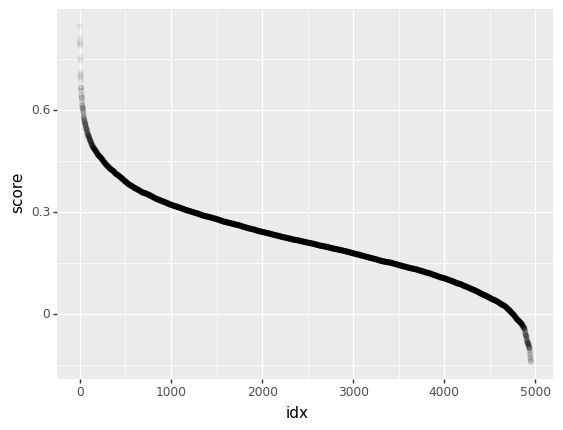

{<ggplot: (8746086049621)>}

In [11]:
from plotnine import *
{ggplot(comparisons, aes("idx", "score")) + geom_point(alpha=.05)}

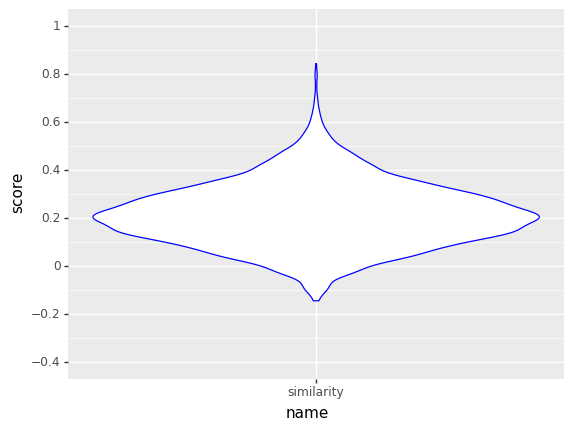

{<ggplot: (8746085968650)>}

In [12]:
from plotnine import *
{
    ggplot(comparisons, aes("name", "score")) +
    geom_violin(color="blue") + 
    scale_y_continuous(limits=[-0.4, 1.0], breaks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
}

## Listing 13.17


### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [ ]:
import nmslib
# initialize a new index, using a HNSW index on Dot Product
titles_index = nmslib.init(method="hnsw", space="negdotprod")
normalized_embeddings = list(map(normalize_embedding, embeddings))
titles_index.addDataPointBatch(normalized_embeddings)
titles_index.createIndex(print_progress=True)

## Listing 13.18

In [ ]:
#dedup these two functions from 13.3
def print_labels(prefix, matches):
    display(HTML(f"<h4>Results for: <em>{prefix}</em></h4>"))
    for l, d in matches:
        print(str(int(d * 1000) / 1000), "|", l)
        
def embedding_search(index, query, phrases, k=20, min_similarity=0.75):
    matches = []
    query_embedding = transformer.encode(query, convert_to_tensor=True)
    query_embedding = normalize_embedding(query_embedding)
    ids, distances = index.knnQuery(query_embedding, k=k)
    for i in range(len(ids)):
        distance = distances[i] * -1
        if distance > min_similarity:
            matches.append((phrases[ids[i]], distance))
    if not len(matches):
        matches.append((phrases[ids[1]], distances[1] * -1))
    return matches

def semantic_search(query, phrases):
    results = embedding_search(titles_index, query, phrases,
                               k=5, min_similarity=0.6)   
    print_labels(query, results)  

In [ ]:
semantic_search("mountain hike", titles)

## Listing 13.19
Perform vector search utilizing our configured search engine

In [ ]:
import json


cache_name = "all_outdoors_title_embeddings"

def index_outdoor_title_embeddings():
    create_view_from_collection(engine.get_collection("outdoors"),
                                "outdoors")
    outdoors_dataframe = spark.sql("""SELECT id, title FROM outdoors
                                      WHERE title IS NOT NULL""")
    print(f"Calculating Embeddings for {outdoors_dataframe.count()} movies.")
    ids = outdoors_dataframe.rdd.map(lambda x: x.id).collect()
    titles = outdoors_dataframe.rdd.map(lambda x: x.title).collect()
    embeddings = list(map(normalize_embedding,
                          get_embeddings(titles, cache_name)))
    embeddings_dataframe = spark.createDataFrame(zip(ids, titles, embeddings),
                                   schema=["id", "title", "title_embedding"])
    
    collection = engine.create_collection("outdoors_with_embeddings")
    print(f"Writing {embeddings_dataframe.count()} movies to 'outdoors_with_embeddings'")
    collection.write(embeddings_dataframe)
    return collection
        
def semantic_search_with_engine(collection, query):
    query_vector = normalize_embedding(transformer.encode(query))
    request = {"query": query_vector,
               "query_fields": "title_embedding",
               "quantization_size": "FLOAT32"}
    response = collection.search(**request)    
    print_labels(query, [(d["title"], d["score"])
                         for d in response["docs"]])

In [ ]:
embeddings_collection = index_outdoor_title_embeddings()

In [ ]:
embeddings_collection = engine.get_collection("outdoors_with_embeddings")
search_results = semantic_search_with_engine(embeddings_collection, "mountain hike")

In [ ]:
#Now, let’s re-rank by using a higher-accuracy cross-encoder model. We’ll use the cross-encoder/ms-marco-MiniLM-L-6-v2 model. 
#This model was trained with the MS MARCO Passage Retrieval dataset, a large dataset with real search questions and their relevant text passages. 
#That makes the model quite suitable for making predictions using questions and passages.
#We’ll use the same question and the top 10 chunks we got from the bi-encoder. Let’s see the results! Recall that cross-encoders expect pairs, so we’ll create pairs of the question and each chunk.

from sentence_transformers import  CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2') #trained for question / passage retrieval

query = "mountain hike"
pair_to_score = [[query, chunks[hit['corpus_id']]] for hit in search_results]
cross_scores = cross_encoder.predict(cross_inp)
cross_scores

## Visualize the titles in 3d vector space

In [ ]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = embeddings.numpy()
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = titles_index.knnQuery(embeddings[100], k=2)
label_ids += [idx for idx in ids]
ids,_ = titles_index.knnQuery(embeddings[505], k=2)
label_ids += [idx for idx in ids]
label_texts += [titles[idx].lower() for idx in label_ids]
markers = ["v"]*len(vectors)

components = pandas.DataFrame({
    "x": pca_data[:,0],
    "y": pca_data[:,1],
    "z": pca_data[:,2]
})

ax = plt.figure(figsize=(24,16)).gca(projection="3d")
ax.scatter(
    components["x"].values, 
    components["y"].values, 
    c=components["y"].values, 
    marker="v", 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components["x"][i]
    y = components["y"][i]
    z = components["z"][i]
    zdir = "y"
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel("PCA X Label")
ax.set_ylabel("PCA Y Label")
ax.set_zlabel("PCA Z Label")
plt.show()

Up next: [Chapter 14: Question Answering with a Fine-tuned Large Language Model](../ch14/1.question-answering-visualizer.ipynb)